In [10]:
import synapse_pb.frame_pb2
import delimited_protobuf
import numpy as np
import matplotlib.pyplot as plt

data = {
    "imu": [],
    "imu_q31_array": [],
    "pwm": [],
    "input": [],
}


def q31_to_double(q31_value, shift):
    if q31_value > 1 << 31 or q31_value < -(1 << 31):
        raise IOError("out of range")
    return q31_value / (1 << (31 - shift))


retry = 0

with open("data.pb", "rb") as file:
    while True:
        try:
            frame = delimited_protobuf.read(file, synapse_pb.frame_pb2.Frame)
            if frame is None:
                break
        except Exception as e:
            print(e)
            print(file.tell())
            file.seek(file.tell() + 1)
            size = _read_varint(file)
            if size == 0:
                break

        match frame.WhichOneof("msg"):
            case "imu":
                msg = frame.imu
                t = msg.stamp.seconds + msg.stamp.nanos * 1e-9
                gx = msg.angular_velocity.x
                gy = msg.angular_velocity.y
                gz = msg.angular_velocity.z
                ax = msg.linear_acceleration.x
                ay = msg.linear_acceleration.y
                az = msg.linear_acceleration.z
                data["imu"].append((t, gx, gy, gz, ax, ay, az))
            case "pwm":
                msg = frame.pwm
                t = msg.timestamp.seconds + msg.timestamp.nanos * 1e-9
                data["pwm"].append(
                    (t, msg.channel[0], msg.channel[1], msg.channel[2], msg.channel[3])
                )
            case "input":
                msg = frame.input
                t = msg.timestamp.seconds + msg.timestamp.nanos * 1e-9
                data["input"].append(
                    (t, msg.channel[0], msg.channel[1], msg.channel[2], msg.channel[3])
                )
            case "imu_q31_array":
                msg = frame.imu_q31_array
                t = msg.stamp.seconds + msg.stamp.nanos * 1e-9
                for f in msg.frame:
                    dt = f.delta_nanos * 1e-9
                    data["imu_q31_array"].append(
                        (
                            t + dt,
                            q31_to_double(f.gyro_x, msg.gyro_shift),
                            q31_to_double(f.gyro_y, msg.gyro_shift),
                            q31_to_double(f.gyro_z, msg.gyro_shift),
                            q31_to_double(f.accel_x, msg.accel_shift),
                            q31_to_double(f.accel_y, msg.accel_shift),
                            q31_to_double(f.accel_z, msg.accel_shift),
                            q31_to_double(f.temp, msg.temp_shift),
                        )
                    )
            case _:
                pass
                # print('unknown', frame.WhichOneof('msg'))

data["imu"] = np.array(
    object=data["imu"],
    dtype=[
        ("t", "f8"),
        ("gx", "f8"),
        ("gy", "f8"),
        ("gz", "f8"),
        ("ax", "f8"),
        ("ay", "f8"),
        ("az", "f8"),
    ],
)

data["imu_q31_array"] = np.array(
    object=data["imu_q31_array"],
    dtype=[
        ("t", "f8"),
        ("gx", "f8"),
        ("gy", "f8"),
        ("gz", "f8"),
        ("ax", "f8"),
        ("ay", "f8"),
        ("az", "f8"),
        ("temp", "f8"),
    ],
)

data["pwm"] = np.array(
    object=data["pwm"],
    dtype=[("t", "f8"), ("c0", "f8"), ("c1", "f8"), ("c2", "f8"), ("c3", "f8")],
)

data["input"] = np.array(
    object=data["input"],
    dtype=[("t", "f8"), ("c0", "f8"), ("c1", "f8"), ("c2", "f8"), ("c3", "f8")],
)

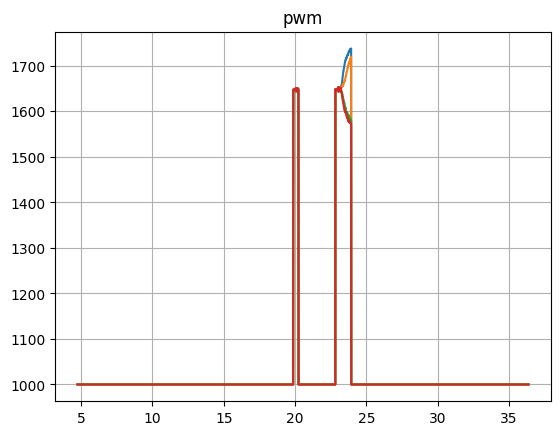

In [13]:
plt.title("pwm")
plt.plot(data["pwm"]["t"], data["pwm"]["c0"])
plt.plot(data["pwm"]["t"], data["pwm"]["c1"])
plt.plot(data["pwm"]["t"], data["pwm"]["c2"])
plt.plot(data["pwm"]["t"], data["pwm"]["c3"])
plt.grid()
# plt.gca().set_xlim([0, 45])

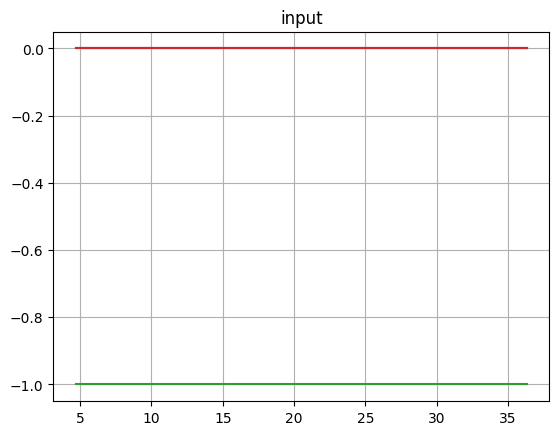

In [18]:
plt.title("input")
plt.plot(data["input"]["t"], data["input"]["c0"])
plt.plot(data["input"]["t"], data["input"]["c1"])
plt.plot(data["input"]["t"], data["input"]["c2"])
plt.plot(data["input"]["t"], data["input"]["c3"])
plt.grid()

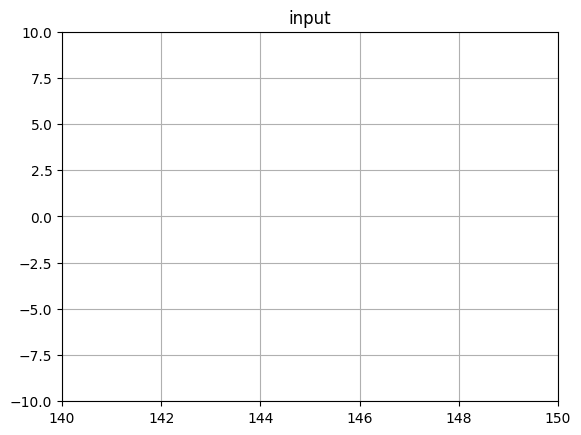

In [19]:
plt.title("input")
# plt.plot(data['input']['t'], data['input']['c0'])
# plt.plot(data['input']['t'], data['input']['c1'])
plt.plot(data["input"]["t"], data["input"]["c2"])
plt.plot(data["imu"]["t"], data["imu"]["gx"], label="x")
plt.plot(data["imu"]["t"], data["imu"]["gy"], label="y")
plt.plot(data["imu"]["t"], data["imu"]["gz"], label="z")
plt.gca().set_xlim(140, 150)
plt.gca().set_ylim(-10, 10)
# plt.plot(data['input']['t'], data['input']['c3'])
plt.grid()

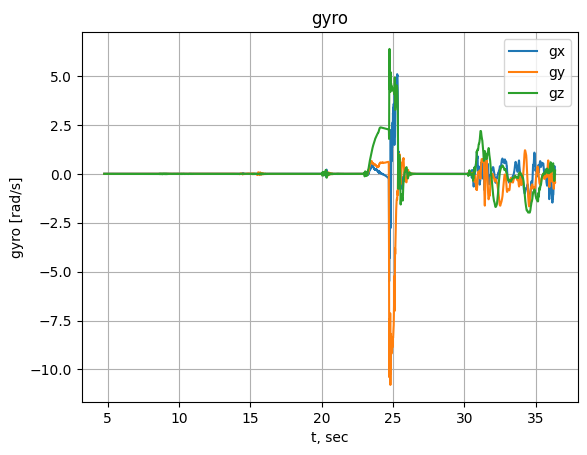

In [20]:
plt.title("gyro")
plt.plot(data["imu"]["t"], data["imu"]["gx"], label="gx")
plt.plot(data["imu"]["t"], data["imu"]["gy"], label="gy")
plt.plot(data["imu"]["t"], data["imu"]["gz"], label="gz")
plt.xlabel("t, sec")
plt.ylabel("gyro [rad/s]")
plt.grid()
plt.legend()
# plt.gca().set_xlim([42, 45])

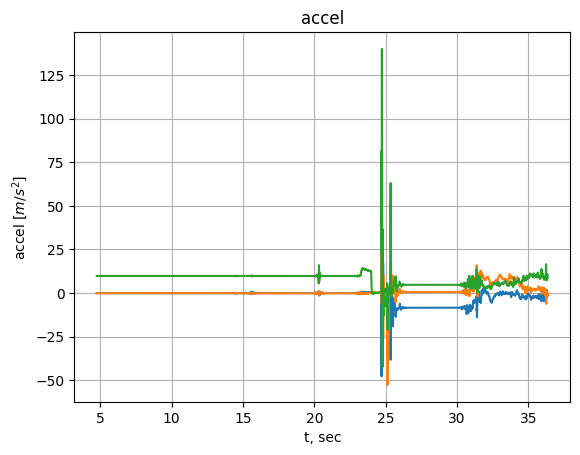

In [21]:
plt.title("accel")
plt.plot(data["imu"]["t"], data["imu"]["ax"])
plt.plot(data["imu"]["t"], data["imu"]["ay"])
plt.plot(data["imu"]["t"], data["imu"]["az"])
plt.xlabel("t, sec")
plt.ylabel(r"accel [$m/s^2$]")
plt.grid()

In [22]:
def plot_power_spectrum(t, x, *args, **kwargs):
    dt = np.diff(t).mean()
    n = len(t)
    ak = np.fft.ifft(x)
    freq = np.fft.fftfreq(len(ak), dt)
    pow = np.abs(ak)
    plt.plot(freq[: n // 2], pow[: n // 2], *args, **kwargs)
    plt.grid()
    plt.xlabel("freq, Hz")
    plt.ylabel("|ak|")

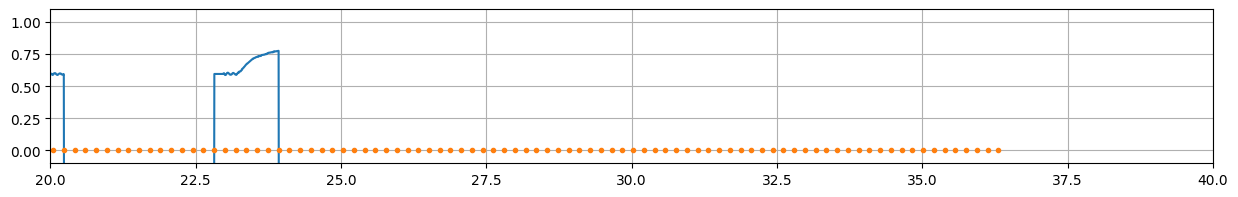

In [23]:
plt.figure(figsize=(15, 2))
plt.plot(data["pwm"]["t"], (data["pwm"]["c0"] - 1350) / 500)
# plt.plot(data['pwm']['t'], data['pwm']['c1'])
# plt.plot(data['pwm']['t'], data['pwm']['c2'])
# plt.plot(data['pwm']['t'], data['pwm']['c3'])
plt.plot(data["input"]["t"], (data["input"]["c2"] + 1) / 2, ".")
plt.gca().set_xlim(20, 40)
plt.gca().set_ylim(-0.1, 1.1)
plt.grid()

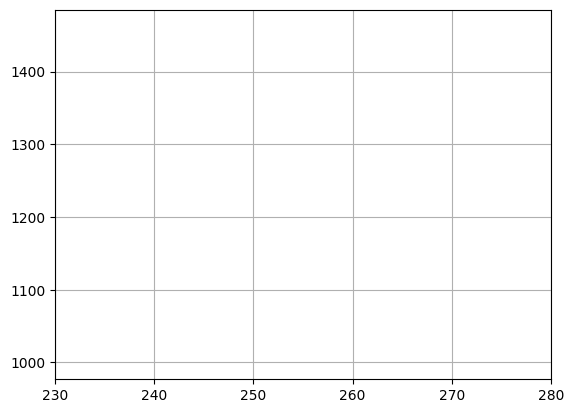

In [43]:
plt.plot(data["pwm"]["t"], data["pwm"]["c2"])
plt.gca().set_xlim(230, 280)
plt.grid()

/tmp/ipykernel_152893/614920422.py:2: RuntimeWarning: Mean of empty slice.
  dt = np.diff(t).mean()
/home/jgoppert/cognipilot/tools/src/cyecca/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Invalid number of FFT data points (0) specified.

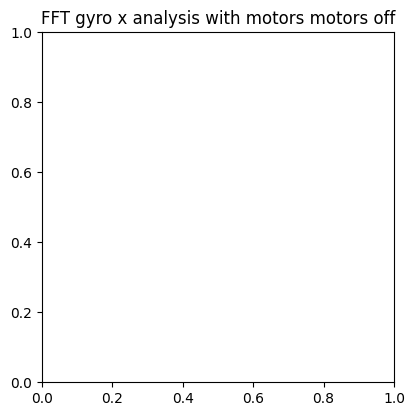

In [15]:
t_off = np.logical_and(
    data["imu_q31_array"]["t"] > 10, data["imu_q31_array"]["t"] < 200
)
t_slow = np.logical_and(
    data["imu_q31_array"]["t"] > 240, data["imu_q31_array"]["t"] < 245
)
t_med = np.logical_and(
    data["imu_q31_array"]["t"] > 250, data["imu_q31_array"]["t"] < 260
)
t_fast = np.logical_and(
    data["imu_q31_array"]["t"] > 265, data["imu_q31_array"]["t"] < 272
)

t2_off = np.logical_and(data["imu"]["t"] > 10, data["imu"]["t"] < 200)
t2_slow = np.logical_and(data["imu"]["t"] > 240, data["imu"]["t"] < 245)
t2_med = np.logical_and(data["imu"]["t"] > 250, data["imu"]["t"] < 260)
t2_fast = np.logical_and(data["imu"]["t"] > 265, data["imu"]["t"] < 272)

plt.figure(figsize=(10, 10))
for i, label in enumerate(["motors off", "motors slow", "motors med", "motors fast"]):
    if label == "motors off":
        t_plot = np.logical_and(
            data["imu_q31_array"]["t"] > 10, data["imu_q31_array"]["t"] < 200
        )
        t2_plot = np.logical_and(data["imu"]["t"] > 10, data["imu"]["t"] < 200)
    elif label == "motors slow":
        t_plot = np.logical_and(
            data["imu_q31_array"]["t"] > 240, data["imu_q31_array"]["t"] < 245
        )
        t2_plot = np.logical_and(data["imu"]["t"] > 240, data["imu"]["t"] < 245)
    elif label == "motors med":
        t_med = np.logical_and(
            data["imu_q31_array"]["t"] > 250, data["imu_q31_array"]["t"] < 260
        )
        t2_med = np.logical_and(data["imu"]["t"] > 250, data["imu"]["t"] < 260)
    elif label == "motors fast":
        t_fast = np.logical_and(
            data["imu_q31_array"]["t"] > 265, data["imu_q31_array"]["t"] < 272
        )
        t2_fast = np.logical_and(data["imu"]["t"] > 265, data["imu"]["t"] < 272)

    plt.subplot(2, 2, i + 1)
    plt.title("FFT gyro x analysis with motors {:s}".format(label))
    plot_power_spectrum(
        t=data["imu_q31_array"]["t"][t_plot],
        x=data["imu_q31_array"]["gx"][t_plot],
        label=label,
    )
    plot_power_spectrum(
        t=data["imu"]["t"][t2_plot], x=data["imu"]["gx"][t2_plot], label=label + " filt"
    )
    plt.gca().set_xlim(0, 200)
    plt.gca().set_ylim(0, 0.01)
    plt.legend()
plt.savefig("fft_with_motors")

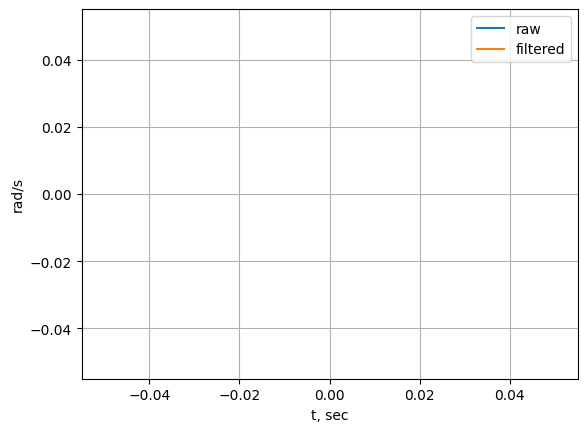

In [16]:
t_plot = np.logical_and(
    data["imu_q31_array"]["t"] > 230.5, data["imu_q31_array"]["t"] < 232
)
t2_plot = np.logical_and(data["imu"]["t"] > 230.5, data["imu"]["t"] < 232)
plt.plot(
    data["imu_q31_array"]["t"][t_plot], data["imu_q31_array"]["gx"][t_plot], label="raw"
)
plt.plot(data["imu"]["t"][t2_plot], data["imu"]["gx"][t2_plot], label="filtered")
plt.legend()
plt.grid()
plt.xlabel("t, sec")
plt.ylabel("rad/s")
plt.savefig("gyro response")

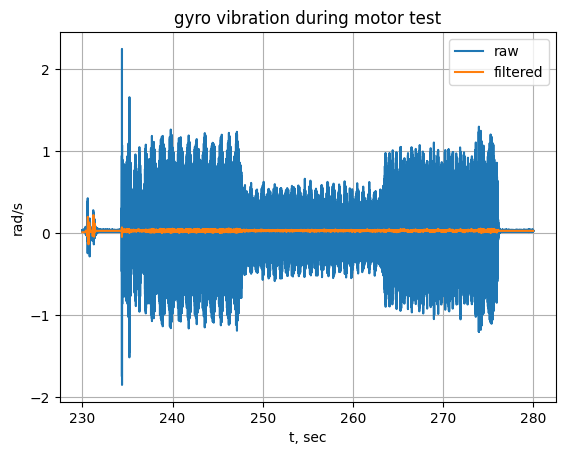

In [328]:
t_plot = np.logical_and(
    data["imu_q31_array"]["t"] > 230, data["imu_q31_array"]["t"] < 280
)
t2_plot = np.logical_and(data["imu"]["t"] > 230, data["imu"]["t"] < 280)
plt.plot(
    data["imu_q31_array"]["t"][t_plot], data["imu_q31_array"]["gx"][t_plot], label="raw"
)
plt.plot(data["imu"]["t"][t2_plot], data["imu"]["gx"][t2_plot], label="filtered")
plt.grid()
plt.xlabel("t, sec")
plt.ylabel("rad/s")
plt.legend()
plt.title("gyro vibration during motor test")
plt.savefig("gyro motor test")

In [292]:
180 / 22

8.181818181818182

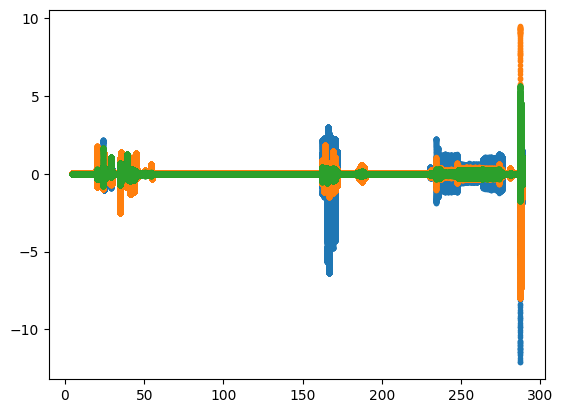

In [293]:
plt.plot(data["imu_q31_array"]["t"], data["imu_q31_array"]["gx"], ".")
plt.plot(data["imu_q31_array"]["t"], data["imu_q31_array"]["gy"], ".")
plt.plot(data["imu_q31_array"]["t"], data["imu_q31_array"]["gz"], ".")

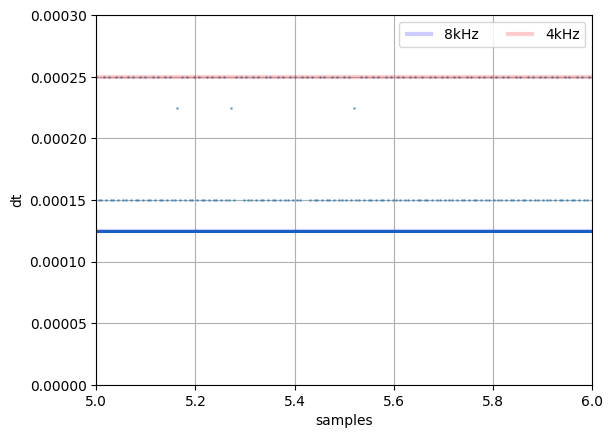

In [294]:
diff = np.diff(data["imu_q31_array"]["t"])
plt.plot(data["imu_q31_array"]["t"][:-1], diff, ".", markersize=2, alpha=0.5)
plt.gca().set_xlim([5, 6])
plt.gca().set_ylim([0, 0.0003])
plt.xlabel("samples")
plt.ylabel("dt")
plt.grid()
plt.hlines(
    1.0 / 8000,
    data["imu_q31_array"]["t"][0],
    data["imu_q31_array"]["t"][-1],
    "b",
    linewidth=3,
    label="8kHz",
    alpha=0.2,
)
plt.hlines(
    1.0 / 4000,
    data["imu_q31_array"]["t"][0],
    data["imu_q31_array"]["t"][-1],
    "r",
    linewidth=3,
    label="4kHz",
    alpha=0.2,
)
plt.legend(ncols=3, loc="best")
plt.savefig("imu sampling")

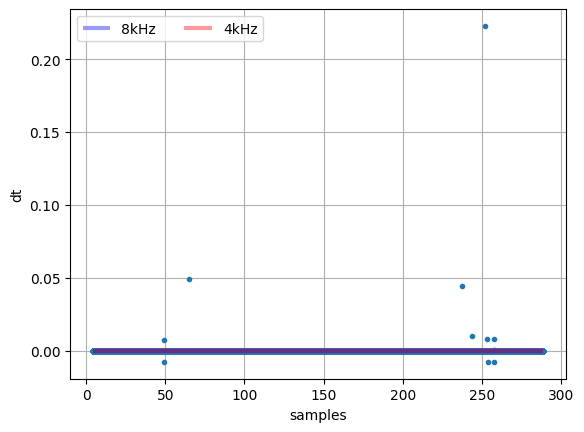

In [295]:
diff = np.diff(data["imu_q31_array"]["t"])
plt.plot(data["imu_q31_array"]["t"][:-1], diff, ".")
plt.xlabel("samples")
plt.ylabel("dt")
plt.grid()
plt.hlines(
    1.0 / 8000,
    data["imu_q31_array"]["t"][0],
    data["imu_q31_array"]["t"][-1],
    "b",
    linewidth=3,
    label="8kHz",
    alpha=0.4,
)
plt.hlines(
    1.0 / 4000,
    data["imu_q31_array"]["t"][0],
    data["imu_q31_array"]["t"][-1],
    "r",
    linewidth=3,
    label="4kHz",
    alpha=0.4,
)
plt.legend(ncols=3, loc="best")
plt.savefig("imu sampling")

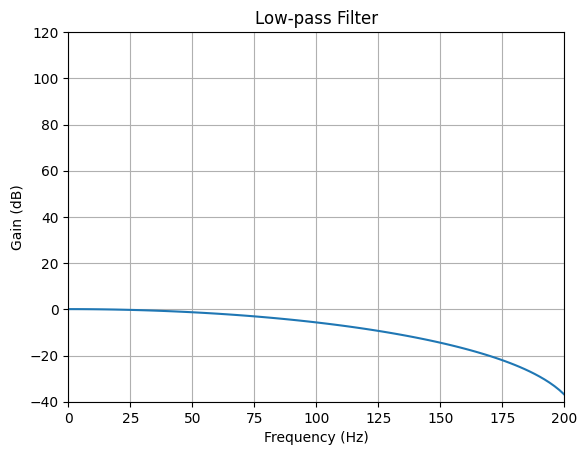

In [296]:
import scipy.signal

fs = 8000
taps = scipy.signal.remez(64, [0, 20, 200, 4000], [1, 0], fs=fs)
w, h = scipy.signal.freqz(taps, [1], worN=2000, fs=fs)


def plot_response(w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(w, 20 * np.log10(np.abs(h)))
    ax.set_ylim(-40, 120)
    ax.set_xlim(0, 200)
    ax.grid(True)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Gain (dB)")
    ax.set_title(title)


plot_response(w, h, "Low-pass Filter")
plt.show()

# Filter Design (IIR)

In [225]:
def plot_filter(b, a, fs, wp, ws, gp, gs, *args, **kwargs):
    w, delay = scipy.signal.group_delay((b, a), fs=fs)

    plt.subplot(311)
    plt.plot(w, 1000 * delay / 8000, ".-", *args, **kwargs)
    plt.gca().set_xlim(0, ws)
    plt.gca().set_ylabel("delay, ms")
    plt.gca().set_ylim(0, 40)
    plt.grid(True)
    plt.vlines(75, 0, 100, "r")

    plt.subplot(312)
    w, h = scipy.signal.freqz(b, a, fs=fs)
    plt.plot(w, 20 * np.log10(np.abs(h)), ".-", *args, **kwargs)
    plt.gca().set_xlim(0, wp)
    plt.gca().set_ylim(-gp * 2, gp * 2)
    plt.hlines([-gp, gp], 0, fs / 2, linestyle="--", colors=["r"])
    plt.gca().set_ylabel("attenuation, dB")
    plt.grid(True)

    plt.subplot(313)
    w, h = scipy.signal.freqz(b, a, fs=fs)
    plt.plot(w, 20 * np.log10(np.abs(h)), ".-", *args, **kwargs)
    plt.hlines([-gs], ws, fs / 2, linestyle="--", colors=["r"])
    plt.gca().set_xlim(ws, 1000)
    plt.gca().set_ylim(-2 * gs, 1)
    plt.gca().set_xlabel("freq, Hz")
    plt.gca().set_ylabel("attenuation, dB")
    plt.grid(True)
    plt.vlines(ws, -100, 0, "r")

butter
cheby1
cheby2
ellip


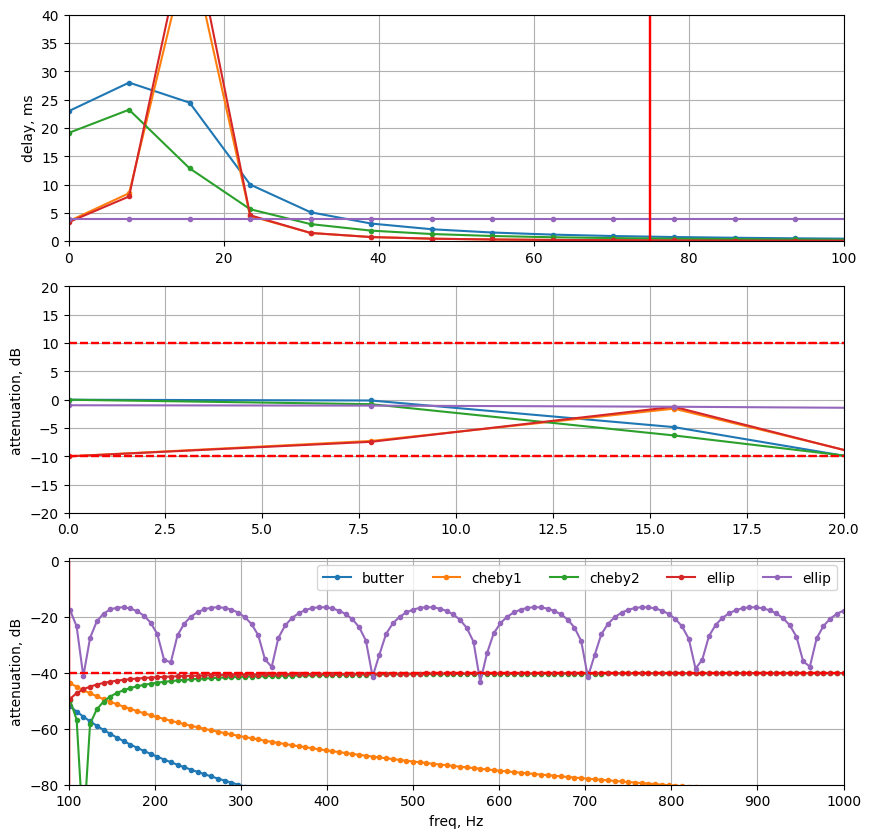

In [278]:
coefs = {}
plt.figure(figsize=(10, 10))

wp = 20  # up to 30 Hz, we won't mess up the signal, more than 12% (1dB)
ws = 100  # at 75 Hz, the signal will be 1/100 of original alue
gp = 10
gs = 40
ntaps = 64
fs = 8000  # 8 kHz sampling freq

for ftype in ["butter", "cheby1", "cheby2", "ellip"]:
    print(ftype)
    (b, a) = scipy.signal.iirdesign(
        wp=wp, ws=ws, gpass=gp, gstop=gs, analog=False, ftype=ftype, fs=fs
    )
    coefs[ftype] = (b, a)
    plot_filter(b, a, fs, wp, ws, gp, gs, label=ftype)

b = scipy.signal.remez(ntaps, [0, wp, ws, fs / 2], [1, 0], fs=fs, type="bandpass")
a = 1
coefs["fir"] = (b, a)
plot_filter(b, a, fs, wp, ws, gp, gs, label=ftype)

plt.legend(loc="best", ncols=6)
plt.savefig("filter design")

In [279]:
def q31_to_double(q31_value, shift):
    if q31_value > 1 << 31 or q31_value < -(1 << 31):
        raise IOError("out of range")
    return q31_value / (1 << (31 - shift))


def double_to_q31(value, shift):
    return int(value * (1 << (31 - shift)))

acc =  b0 * x[n] + b1 * x[n-1] + b2 * x[n-2] + a1 * y[n-1] + a2 * y[n-2]
 
(1  - a1 * z^{-1 - a2 *z^{-2) y[n] =  (b0  + b1 * z^{-1} + b2 * z^{-2}) x[n]
 
y[n] / x[n] = (b0  + b1 * z^{-1} + b2 * z^{-2})  / (1  - a1 * z^{-1 - a2 *z^{-2))
  
y[n] / x[n] = (b0 z^2 + b1 * z + b2 )  / (z^2  - a1 * z - a2 )

$$ y[n] = \frac{b_2 z^{-2} + b_1 z^{-1} + b_0}{1 + a_1 z^{-1} + a_2 z^{-2}} * x[n]$$

$$ y[n] * (1 + a_1 z^{-1} + a_2 z^{-2}) = (b_2 z^{-2} + b_1 z^{-1} + b_0}) * x[n]$$

In [280]:
def print_filter_coeffs_cmsis(b, a, shift):
    sys = scipy.signal.TransferFunction(b, a, dt=1.0 / 8000)
    print("poles", np.abs(sys.poles))
    sos = scipy.signal.tf2sos(b, a)
    print("max", np.max(np.abs(sos)))
    vals = []
    for i in range(len(sos)):
        for j in [1, 2, 0, 4, 5]:
            sign = 1
            if j in [4, 5]:
                sign = -1
            vals.append(double_to_q31(sign * sos[i][j], shift))
    return np.array(vals)


print_filter_coeffs_cmsis(*coefs["butter"], 1)

poles [0.99456915 0.99456915 0.98916747]
max 1.9890498142815956


array([        343,         171,         171,  1062110487,           0,
        1073748887,           0,  1073741824,  2135725975, -1062110830])

In [281]:
print_filter_coeffs_cmsis(*coefs["butter"], 1)

poles [0.99456915 0.99456915 0.98916747]
max 1.9890498142815956


array([        343,         171,         171,  1062110487,           0,
        1073748887,           0,  1073741824,  2135725975, -1062110830])

In [ ]:
a = [1151, 575, 575]
b = [1056341497, 0]